## Impoting Libraries

In [2]:
import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import lil_matrix

## Importing Datasets

In [27]:
# Having Columns of recipe_id, rating and review

In [28]:
rec_interaction = pd.read_csv("RAW_interactions.csv/RAW_interactions.csv", usecols=['recipe_id', 'rating', 'review'])

In [29]:
rec_interaction.head(3)

,recipe_id,rating,review
0,40893,4,Great with a salad. Cooked on top of stove for...
1,40893,5,"So simple, so delicious! Great for chilly fall..."
2,44394,4,This worked very well and is EASY. I used not...


In [30]:
rec_interaction.shape

(1132367, 3)

# Renaming Column Name

In [31]:
# Renaming recipe_id to id
rec_interaction = rec_interaction.rename(columns={'recipe_id': 'id'})

In [32]:
rec_interaction.columns

Index(['id', 'rating', 'review'], dtype='object')

## Loading Second File

In [33]:
# Having columns of id, name, steps, ingredients and minutes

In [34]:
# Loading the Raw Recipes file
raw_recipes = pd.read_csv("Raw_recipes.csv/Raw_recipes.csv", usecols=['id', 'name', 'steps', 'ingredients', 'minutes'])

In [35]:
raw_recipes.head(3)

,name,id,minutes,steps,ingredients
0,arriba baked winter squash mexican style,137739,55,"['make a choice and proceed with recipe', 'dep...","['winter squash', 'mexican seasoning', 'mixed ..."
1,a bit different breakfast pizza,31490,30,"['preheat oven to 425 degrees f', 'press dough...","['prepared pizza crust', 'sausage patty', 'egg..."
2,all in the kitchen chili,112140,130,"['brown ground beef in large pot', 'add choppe...","['ground beef', 'yellow onions', 'diced tomato..."


In [36]:
raw_recipes.shape

(231637, 5)

## Merging Datasets (raw_recipes, rec_interaction)

In [37]:
# Combine the dataframes on recipe_id for enriched data (optional)
recipes_combined = pd.merge(rec_interaction, raw_recipes, on='id', how='left')

In [38]:
recipes_combined.shape

(1132367, 7)

## Preprocessing

In [39]:
recipes_combined.head(3)

,id,rating,review,name,minutes,steps,ingredients
0,40893,4,Great with a salad. Cooked on top of stove for...,white bean green chile pepper soup,495,"['combine beans , onion , chilies , 1 / 2 teas...","['great northern beans', 'yellow onion', 'dice..."
1,40893,5,"So simple, so delicious! Great for chilly fall...",white bean green chile pepper soup,495,"['combine beans , onion , chilies , 1 / 2 teas...","['great northern beans', 'yellow onion', 'dice..."
2,44394,4,This worked very well and is EASY. I used not...,devilicious cookie cake delights,20,"['blend together cake mix , oil and eggs', 'ad...","[""devil's food cake mix"", 'vegetable oil', 'eg..."


## Null Values

In [40]:
# Finding Nulls
recipes_combined.isnull().sum()

id               0
rating           0
review         169
name             1
minutes          0
steps            0
ingredients      0
dtype: int64

In [41]:
# Imputing Null Values

recipes_combined['review'].fillna('No Review', inplace = True)

C:\Users\PC\AppData\Local\Temp\ipykernel_10120\1128063336.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  recipes_combined['review'].fillna('No Review', inplace = True)


In [42]:
# Checking if there is more NaN values
print(recipes_combined['review'].isna().sum())  # Should return 0


0


## Duplicated Values

In [43]:
# Finding Duplicated Values
recipes_combined.duplicated().sum()

60

In [44]:
# View Duplicates
print(recipes_combined[recipes_combined.duplicated()])

             id  rating                                             review  \
12895      9004       5                                             Yummy!   
39324    474694       5                                         Delicious!   
43107    150384       5                                         Delicious!   
49544    449452       5                                          No Review   
56957      9054       5                                          No Review   
56966      9054       5                                          No Review   
88323     97496       5                                           Perfect!   
96917    486453       5                                         Delicious.   
97162    443758       5  Sometimes the best recipes are the simplest on...   
125818    92095       5                                         Delicious!   
159641   351631       5                                          No Review   
181367   101954       5                                         

In [45]:
# Dropping Duplicated Values
recipes_combined.drop_duplicates(inplace=True)

In [46]:
# Checking if the duplicated Rows are dropped or not
recipes_combined.duplicated().sum()

0

## Preprocess Ingredients Column

In [47]:
# Preprocess the 'ingredients', 'steps' columns
recipes_combined['ingredients'] = recipes_combined['ingredients'].apply(lambda x: [i.lower() for i in eval(x)])
recipes_combined['steps'] = recipes_combined['steps'].apply(lambda x: [step.strip().lower() for step in eval(x)])

In [25]:
recipes_combined['ingredients'][0]

['great northern beans',
 'yellow onion',
 'diced green chilies',
 'ground cumin',
 'garlic powder',
 'fat-free chicken broth',
 'fresh cilantro leaves',
 'extra virgin olive oil',
 'sour cream']

In [53]:
recipes_combined['steps'][5]

['carefully pick over the berries , removing leaves , foreign objects , and spoiled berries',
 'place the berries in a mixing bowl , and pour the sugar over them',
 'use two large forks to mash the sugar into the berries until they are liquified and there is no trace of whole berries left',
 "don't use a blender , it will pulverize seeds , and they should be left whole",
 'transfer to jars and refrigerate 2 days before using',
 'they will keep one year refrigerated']

## Formatting Steps

In [59]:
def format_steps(steps):
    # Convert the list of steps into numbered points
    formatted_steps = [f"{i + 1}. {step.capitalize()}" for i, step in enumerate(steps)]
    return "\n".join(formatted_steps)


In [56]:
recipes_combined['formatted_steps'] = recipes_combined['steps'].apply(format_steps)


In [60]:
# Example usage
recipes_combined['formatted_steps'][5]

"1. Carefully pick over the berries , removing leaves , foreign objects , and spoiled berries\n2. Place the berries in a mixing bowl , and pour the sugar over them\n3. Use two large forks to mash the sugar into the berries until they are liquified and there is no trace of whole berries left\n4. Don't use a blender , it will pulverize seeds , and they should be left whole\n5. Transfer to jars and refrigerate 2 days before using\n6. They will keep one year refrigerated"

#### EDA

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


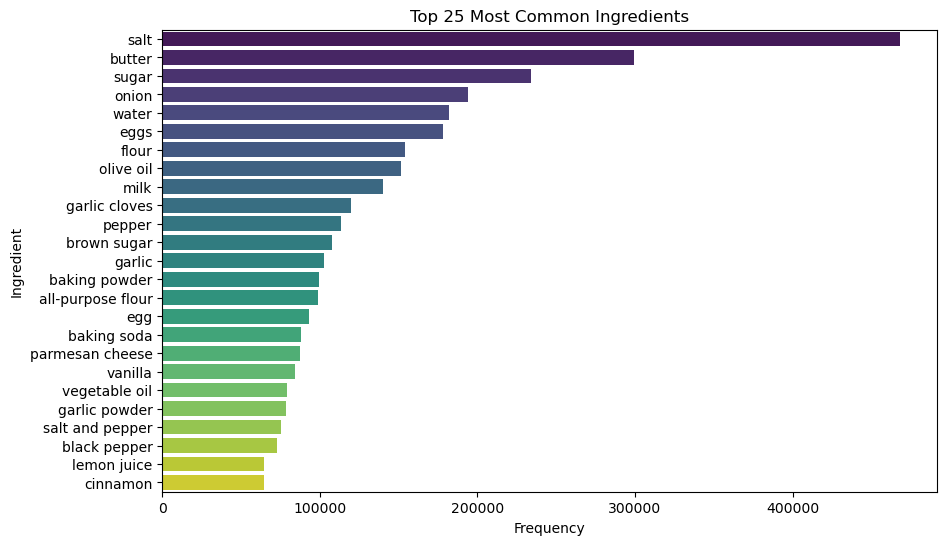

In [61]:
import nltk
from nltk import FreqDist

# Flatten the list of ingredients into one long list
all_ingredients = [ingredient for sublist in recipes_combined['ingredients'] for ingredient in sublist]

# Create a frequency distribution
fdist = FreqDist(all_ingredients)

# Get the top 20 most common ingredients
top_10_ingredients = fdist.most_common(25)

# Prepare the data for plotting
ingredients_top = [item[0] for item in top_10_ingredients]
counts_top = [item[1] for item in top_10_ingredients]

# Plotting using Seaborn's barplot (Frequency distribution)
plt.figure(figsize=(10, 6))
sns.barplot(x=counts_top, y=ingredients_top, palette="viridis")

plt.title("Top 25 Most Common Ingredients")
plt.xlabel("Frequency")
plt.ylabel("Ingredient")
plt.show()


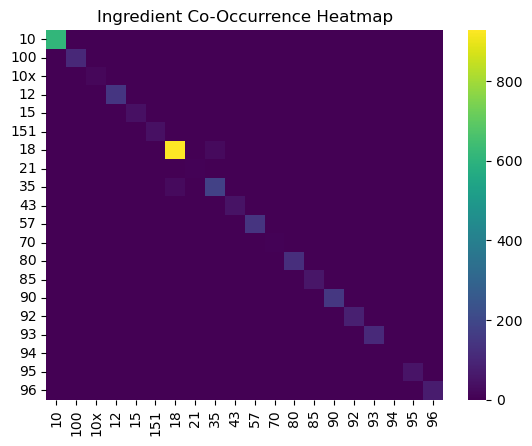

In [69]:
from sklearn.feature_extraction.text import CountVectorizer

ingredient_strs = recipes_combined['ingredients'].apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer()
ingredient_matrix = vectorizer.fit_transform(ingredient_strs)
ingredient_cooccurrence = (ingredient_matrix.T * ingredient_matrix).toarray()

sns.heatmap(ingredient_cooccurrence[:20, :20], cmap='viridis', xticklabels=vectorizer.get_feature_names_out()[:20], yticklabels=vectorizer.get_feature_names_out()[:20])
plt.title('Ingredient Co-Occurrence Heatmap')
plt.show()


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


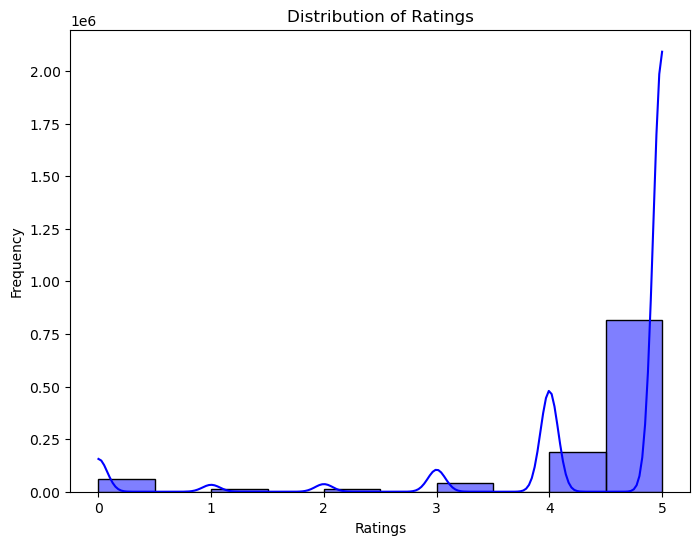

In [62]:
# Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.histplot(recipes_combined['rating'], bins=10, kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()


In [94]:
# Knowing more about Dataset

In [82]:
print(recipes_combined.columns)


Index(['id', 'rating', 'review', 'name', 'minutes', 'steps', 'ingredients',
       'formatted_steps', 'time_category', 'ingredient_count'],
      dtype='object')


In [84]:
recipes_combined['ingredients']


2          [devil's food cake mix, vegetable oil, eggs, r...
3          [mayonnaise, salsa, cheddar cheese, refried be...
4          [mayonnaise, salsa, cheddar cheese, refried be...
5                            [raspberries, granulated sugar]
6                            [raspberries, granulated sugar]
                                 ...                        
1132362    [peaches, brown sugar, allspice, maple syrup, ...
1132363    [carrot, garbanzo beans, salsa, corn flakes, w...
1132364    [boneless beef chuck roast, olive oil, tawny p...
1132365    [boneless beef chuck roast, olive oil, tawny p...
1132366    [boneless beef chuck roast, olive oil, tawny p...
Name: ingredients, Length: 1016774, dtype: object

In [85]:
print(type(recipes_combined['ingredients']))


<class 'pandas.core.series.Series'>


In [86]:
recipes_combined['ingredient_count'] = recipes_combined['ingredients'].apply(len)
print(recipes_combined[['ingredients', 'ingredient_count']].head())


                                         ingredients  ingredient_count
2  [devil's food cake mix, vegetable oil, eggs, r...                 4
3  [mayonnaise, salsa, cheddar cheese, refried be...                13
4  [mayonnaise, salsa, cheddar cheese, refried be...                13
5                    [raspberries, granulated sugar]                 2
6                    [raspberries, granulated sugar]                 2


In [92]:
# Access using .iloc
ingredient_count_value = recipes_combined['ingredient_count'].iloc[0]
print(ingredient_count_value)


4


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


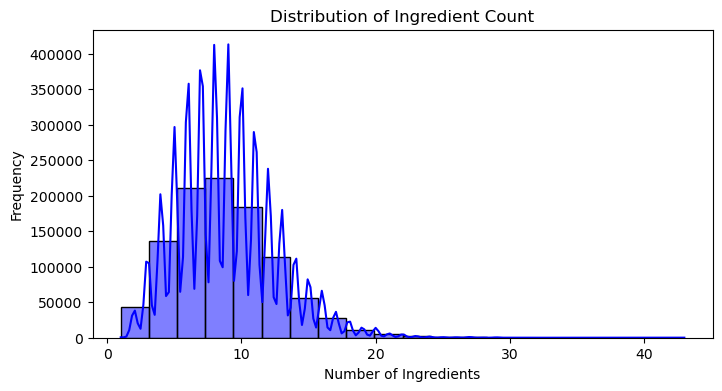

In [89]:
# Distribution of Ingredient Count 

plt.figure(figsize=(8, 4))
sns.histplot(recipes_combined['ingredient_count'], bins=20, kde=True, color='blue')
plt.title('Distribution of Ingredient Count')
plt.xlabel('Number of Ingredients')
plt.ylabel('Frequency')
plt.show()


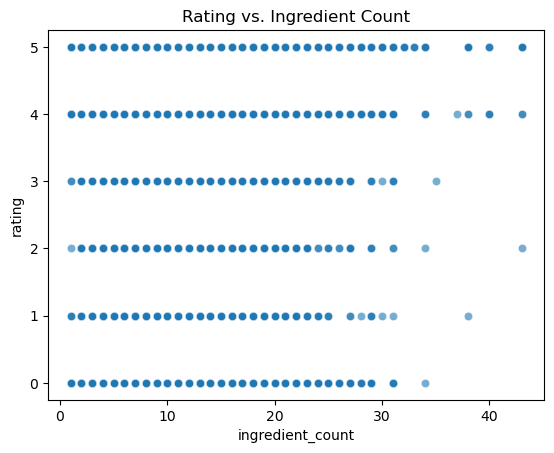

In [93]:
# Rating Vs Ingredient Count
sns.scatterplot(data=recipes_combined, x='ingredient_count', y='rating', alpha=0.6)
plt.title('Rating vs. Ingredient Count')
plt.show()


C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


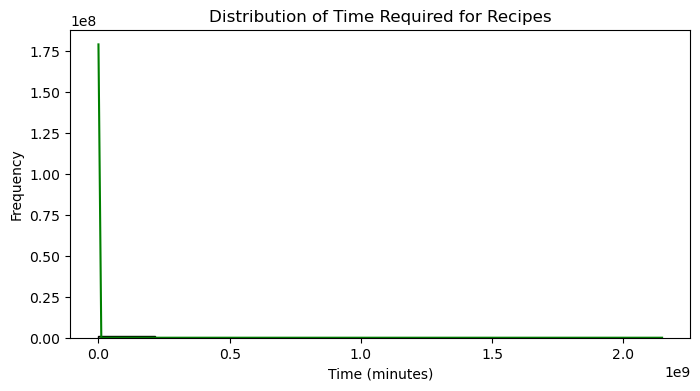

In [63]:
# Distribution of Time Required for Recipes
plt.figure(figsize=(8, 4))
sns.histplot(recipes_combined['minutes'], bins=10, kde=True, color='green')
plt.title('Distribution of Time Required for Recipes')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.show()

## Removing Outliers in 'minutes' column

In [64]:
Q1 = recipes_combined['minutes'].quantile(0.25)
Q3 = recipes_combined['minutes'].quantile(0.75)
IQR = Q3 - Q1


In [66]:
# Finding Lower and Upper Bound

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


In [67]:
# Apply on minutes Column
recipes_combined = recipes_combined[(recipes_combined['minutes'] >= lower_bound) & (recipes_combined['minutes'] <= upper_bound)]


## Time Analysis

C:\Users\PC\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


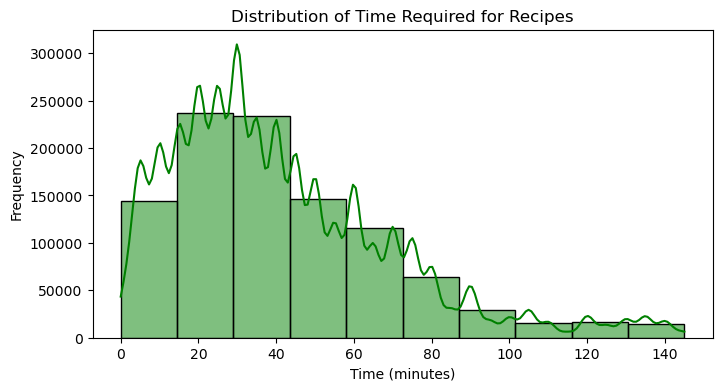

In [68]:
# Distribution of Time Required for Recipes
plt.figure(figsize=(8, 4))
sns.histplot(recipes_combined['minutes'], bins=10, kde=True, color='green')
plt.title('Distribution of Time Required for Recipes')
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')
plt.show()

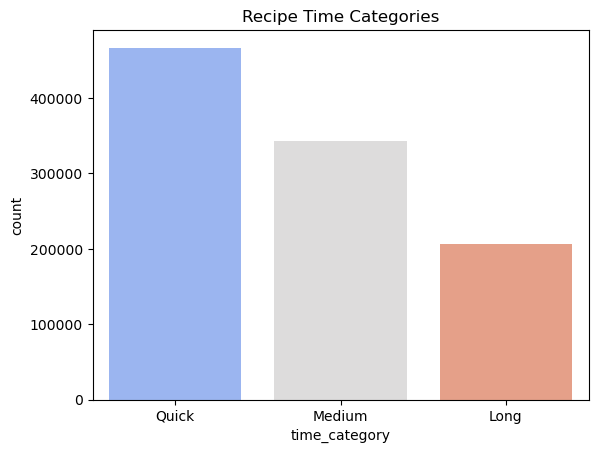

In [70]:
recipes_combined['time_category'] = recipes_combined['minutes'].apply(lambda x: 'Quick' if x <= 30 else ('Medium' if x <= 60 else 'Long'))
sns.countplot(data=recipes_combined, x='time_category', palette='coolwarm')
plt.title('Recipe Time Categories')
plt.show()


## Sentiment Analysis of 'Reviews'

In [95]:
# !pip install textblob

In [96]:

from textblob import TextBlob
recipes_combined['sentiment'] = recipes_combined['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
recipes_combined['sentiment_label'] = recipes_combined['sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))


In [97]:
recipes_combined['sentiment_label']

2          positive
3          positive
4          negative
5          positive
6          positive
             ...   
1132362    positive
1132363    positive
1132364    positive
1132365    positive
1132366    positive
Name: sentiment_label, Length: 1016774, dtype: object

In [98]:
recipes_combined['sentiment_label'].value_counts()

sentiment_label
positive    952392
negative     43662
neutral      20720
Name: count, dtype: int64

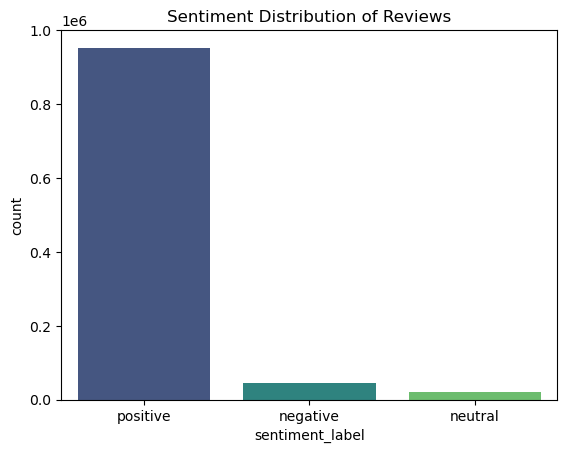

In [99]:
# Visualize the distribution of sentiments in reviews.

sns.countplot(data=recipes_combined, x='sentiment_label', palette='viridis')
plt.title('Sentiment Distribution of Reviews')
plt.show()


## Machine Learning Approach

## Building Model

## At least 2 Matches

In [30]:
def recommend_recipes(user_ingredients, recipes_combined, n_neighbors=5, min_matches=2):
    # Count the number of matching ingredients for each recipe
    recipes_combined['match_count'] = recipes_combined['ingredients'].apply(
        lambda x: sum(ingredient in x for ingredient in user_ingredients)
    )
    
    # Filter recipes with at least `min_matches` ingredients matching
    filtered_recipes = recipes_combined[recipes_combined['match_count'] >= min_matches]
    
    if filtered_recipes.empty:
        return f"No recipes found with at least {min_matches} matching ingredients."
    
    # Reset index of filtered recipes to ensure KNN indices map correctly
    filtered_recipes_reset = filtered_recipes.reset_index(drop=True)
    
    # Prepare the data for KNN
    recipe_ingredients_matrix = filtered_recipes_reset['ingredients'].apply(lambda x: set(x))
    user_ingredient_set = set(user_ingredients)
    
    # Create a list of all ingredients present in the dataset
    all_ingredients = sorted(set([ingredient for sublist in recipe_ingredients_matrix for ingredient in sublist]))
    
    # Create a sparse matrix (using LIL format for fast row slicing)
    recipe_vectors = lil_matrix((len(filtered_recipes_reset), len(all_ingredients)))
    
    # Fill the sparse matrix with binary values
    ingredient_index = {ingredient: idx for idx, ingredient in enumerate(all_ingredients)}
    
    for i, ingredients in enumerate(recipe_ingredients_matrix):
        for ingredient in ingredients:
            recipe_vectors[i, ingredient_index[ingredient]] = 1
    
    # Fit the KNN model using the sparse matrix
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(recipe_vectors)
    
    # Query the user's ingredients
    user_vector = lil_matrix((1, len(all_ingredients)))
    for ingredient in user_ingredient_set:
        if ingredient in ingredient_index:
            user_vector[0, ingredient_index[ingredient]] = 1
    
    # Query the KNN model to get the nearest neighbors
    distances, indices = knn.kneighbors(user_vector)
    
    # Get recommended recipes based on KNN results
    recommended_recipes = filtered_recipes_reset.iloc[indices[0]]
    
    # Remove duplicate recipes based on the name
    recommended_recipes_unique = recommended_recipes.drop_duplicates(subset='name')
    
    # Sort by match_count, rating, then by the length of the review (as a proxy for popularity)
    recommended_recipes_sorted = recommended_recipes_unique.sort_values(
        by=['match_count', 'rating', 'review'], ascending=[False, False, False]
    )
    
    # Return the top n_neighbors unique recipes
    return recommended_recipes_sorted[['name', 'rating', 'review', 'ingredients', 'steps']].head(n_neighbors)


In [32]:
user_ingredients = ['cheese', 'onion', 'chicken', 'catch up']
recommended_recipes = recommend_recipes(user_ingredients, recipes_combined, n_neighbors=5)
print(recommended_recipes)


                     name  rating  \
6867  chicken cheese ball       5   

                                                 review  \
6867  I used left over chicken breast and also added...   

                                          ingredients  \
6867  [cream cheese, chicken, mustard, onion, cheese]   

                                                  steps  
6867  ['mix all ingredients', 'shape into a ball and...  


## Model

In [287]:
from scipy.sparse import save_npz, load_npz
import joblib

# Vectorization
def vectorize_ingredients(recipes_combined):
    recipes_combined['ingredients_str'] = recipes_combined['ingredients'].apply(lambda x: ' '.join(x))
    tfidf = TfidfVectorizer(stop_words='english')
    recipe_vectors = tfidf.fit_transform(recipes_combined['ingredients_str'])
    return tfidf, recipe_vectors

# Train KNN Model
def train_knn(recipe_vectors, n_neighbors=5):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(recipe_vectors)
    return knn


## Saving Models

In [290]:
# Save Artifacts
def save_artifacts(recipes_combined, tfidf, recipe_vectors, knn):
    # Save preprocessed dataset
    joblib.dump(recipes_combined,"recipes_combined.pkl")

    # Save the TF-IDF vectorizer
    joblib.dump(tfidf, "tfidf_vectorizer.pkl")

    # Save sparse matrix for recipe vectors
    save_npz("recipe_vectors.npz", recipe_vectors)

    # Save the KNN model
    joblib.dump(knn, "recipes_knn_model.pkl")


In [291]:
# Load Artifacts
def load_artifacts():
    recipes_combined = joblib.load("recipes_combined.pkl")
    tfidf = joblib.load("tfidf_vectorizer.pkl")
    recipe_vectors = load_npz("recipe_vectors.npz")
    knn = joblib.load("recipes_knn_model.pkl")
    return recipes_combined, tfidf, recipe_vectors, knn


## Recommendation

In [292]:
# Recommendation System
def recommend_recipes(user_ingredients, tfidf, knn, recipes_combined, n_neighbors=5):
    # Convert user input to TF-IDF vector
    user_input = ' '.join(user_ingredients)
    user_vector = tfidf.transform([user_input])

    # Query the KNN model
    distances, indices = knn.kneighbors(user_vector, n_neighbors=n_neighbors)

    # Fetch recommended recipes
    recommended_recipes = recipes_combined.iloc[indices[0]]
    recommended_recipes_unique = recommended_recipes.drop_duplicates(subset='name')
    
    return recommended_recipes_unique[['name', 'rating', 'minutes', 'ingredients', 'steps', 'review']]


## Vectorizig and Training

In [293]:
# Vectorize Ingredients and Train KNN
tfidf, recipe_vectors = vectorize_ingredients(recipes_combined)
knn = train_knn(recipe_vectors)

# Save Artifacts
save_artifacts(recipes_combined, tfidf, recipe_vectors, knn)


In [294]:
# Load Artifacts
recipes_combined, tfidf, recipe_vectors, knn = load_artifacts()

In [215]:
knn = load_artifacts()


## Testing

In [295]:
# Get Recommendations
user_ingredients = ['tomato', 'cheese', 'onion', 'chicken']
recommendations = recommend_recipes(user_ingredients, tfidf, knn, recipes_combined)
print(recommendations)

                       name  rating  minutes  \
76456     tangy tomato soup       4       30   
942757  chicken cheese ball       4       20   

                                              ingredients  \
76456   [olive oil, onion, garlic, diced tomatoes, tom...   
942757    [cream cheese, chicken, mustard, onion, cheese]   

                                                    steps  \
76456   ['heat the oil in a soup pot over medium-high ...   
942757  ['mix all ingredients', 'shape into a ball and...   

                                                   review  
76456   I thought this was wonderful, quick and budget...  
942757  We enjoyed this!  Served with Chicken In A Bis...  
